In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import sc_utils
import scvi

Global seed set to 0
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
pd.options.display.max_rows = 200

In [3]:
%config InlineBackend.figure_format = "retina"

# Train jax

Plan:
1. Train scVI on HVG with batches
2. See that its latent space recapitulates what we saw in exploratory
3. Use latent space to predict proteins

Improvement ideas:
1. Add l1 sparsity regularization to loss
2. Select more HVGs
3. Change network setup / layer sizes
4. Tweak loss to distinguish expressed vs non-expressed genes

## 1. Load data

In [4]:
ds = sc.read_h5ad("../data/h5ad/rna.h5ad")

`ds.X` contains scaled values right now, let's get log-normalized gene expression back

In [5]:
ds = ds.raw.to_adata()

This object has `raw` with all genes, but we already selected 2000 HVGs, let's try using these first

In [6]:
ds = ds[:, ds.var.highly_variable].copy()

## 2. jax model

In [7]:
from typing import Iterator, Mapping, Tuple, NamedTuple, Sequence, Union

from absl import app
from absl import flags
from absl import logging
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
import math

In [74]:
batch_size = 128 #"Size of the batch to train on.")
learning_rate = 0.001 # "Learning rate for the optimizer.")
training_steps = 1501 #, "Number of training steps to run.")
eval_frequency = 100 #, "How often to evaluate the model.")
random_seed = 42 #, "Random seed.")
l1_coef = 0.5

In [75]:
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]
HiddenSize = Union[int, tuple]

MNIST_IMAGE_SHAPE: Sequence[int] = (28, 28, 1)

In [83]:
class Encoder(hk.Module):
    """Encoder model."""

    def __init__(self, hidden_size: HiddenSize = 512, latent_size: int = 10):
        super().__init__()
        if not isinstance(hidden_size, tuple):
            hidden_size = (hidden_size,)
        self._hidden_size = hidden_size
        self._latent_size = latent_size

    def __call__(self, x: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        x = hk.Flatten()(x)
        activation_sum = 0
        for layer_size in self._hidden_size:
            x = hk.Linear(layer_size)(x)
            activation_sum += jnp.mean(jnp.abs(x))
            x = jax.nn.leaky_relu(x)

        return hk.Linear(self._latent_size)(x), activation_sum


class Decoder(hk.Module):
    """Decoder model."""

    def __init__(
        self,
        hidden_size: HiddenSize = 512,
        output_shape: Sequence[int] = MNIST_IMAGE_SHAPE,
    ):
        super().__init__()
        if not isinstance(hidden_size, tuple):
            hidden_size = (hidden_size,)
        self._hidden_size = hidden_size
        self._output_shape = output_shape

    def __call__(self, z: jnp.ndarray) -> jnp.ndarray:
        activation_sum = 0
        for layer_size in reversed(self._hidden_size):
            z = hk.Linear(layer_size)(z)
            activation_sum += jnp.mean(jnp.abs(z))
            z = jax.nn.leaky_relu(z)

        return hk.Linear(np.prod(self._output_shape))(z), activation_sum


class AEOutput(NamedTuple):
    data: jnp.ndarray
    latent: jnp.ndarray
    act_sum: float


class AutoEncoder(hk.Module):
    """Main VAE model class, uses Encoder & Decoder under the hood."""

    def __init__(
        self,
        hidden_size: HiddenSize = 512,
        latent_size: int = 10,
        output_shape: Sequence[int] = MNIST_IMAGE_SHAPE,
    ):
        super().__init__()
        self._hidden_size = hidden_size
        self._latent_size = latent_size
        self._output_shape = output_shape

    def __call__(self, x: jnp.ndarray) -> AEOutput:
        x = x.astype(jnp.float32)
        z, act_sum_en = Encoder(self._hidden_size, self._latent_size)(x)
        data, act_sum_de = Decoder(self._hidden_size, self._output_shape)(z)
        act_sum_total = act_sum_en + act_sum_de + jnp.mean(jnp.abs(z))
        return AEOutput(data, z, act_sum_total)

In [84]:
@jax.jit
def loss_fn(params: hk.Params, batch) -> jnp.ndarray:
    output: AEOutput = model.apply(params, batch)
    return jnp.mean(jnp.square(batch - output.data)) + l1_coef * output.act_sum

In [85]:
@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

In [86]:
model = hk.transform(
    lambda x: AutoEncoder(
        hidden_size=(2000, 256, 128),
        latent_size=64, # TODO: try different sizes, including 1
        output_shape=(2000,)
    )(x)
)  # pylint: disable=unnecessary-lambda
model = hk.without_apply_rng(model)
optimizer = optax.adam(learning_rate)

In [87]:
rng = jax.random.PRNGKey(1066)
params = model.init(rng, np.zeros((2000,)))
opt_state = optimizer.init(params)

In [88]:
split_idx = math.floor(ds.X.shape[0] * 0.9)

In [89]:
train_ds, val_ds = ds.X[:split_idx], ds.X[split_idx:]
num_complete_batches, leftover = divmod(train_ds.shape[0], batch_size)
num_batches = num_complete_batches + bool(leftover)

In [90]:
for step in range(training_steps):
    i = step % num_batches
    batch = jax.lax.dynamic_slice_in_dim(train_ds, i * batch_size, batch_size)
    params, opt_state = update(params, opt_state, batch)

    if step % eval_frequency == 0:
        num_val_batches = val_ds.shape[0] // batch_size
        i = step % num_val_batches
        val_batch = jax.lax.dynamic_slice_in_dim(val_ds, i * batch_size, batch_size)
        output: AEOutput = model.apply(params, val_batch)
        loss = jnp.mean(jnp.square(val_batch - output.data))
        print("STEP: %5d; Validation loss: %.3f" % (step, loss))

STEP:     0; Validation loss: 4.547
STEP:   100; Validation loss: 2.129
STEP:   200; Validation loss: 1.795
STEP:   300; Validation loss: 1.586
STEP:   400; Validation loss: 1.817
STEP:   500; Validation loss: 1.598
STEP:   600; Validation loss: 1.737
STEP:   700; Validation loss: 1.997
STEP:   800; Validation loss: 1.716
STEP:   900; Validation loss: 1.502
STEP:  1000; Validation loss: 1.449
STEP:  1100; Validation loss: 1.474
STEP:  1200; Validation loss: 1.462
STEP:  1300; Validation loss: 1.443
STEP:  1400; Validation loss: 1.463
STEP:  1500; Validation loss: 1.423


In [39]:
output: AEOutput = model.apply(params, ds.X)

In [37]:
jnp.save("04jax.model", params)

In [43]:
output.latent.shape

(119651, 16)

In [48]:
ds.obsm["X_jax"] = np.array(output.latent)

In [50]:
sc.pp.neighbors(ds, use_rep="X_jax", key_added="jax_neighbors")

In [51]:
sc.tl.leiden(ds, key_added="jax_leiden", neighbors_key="jax_neighbors")

/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projects/b1038/Pulmonary/nmarkov/2022-multimodal/code/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


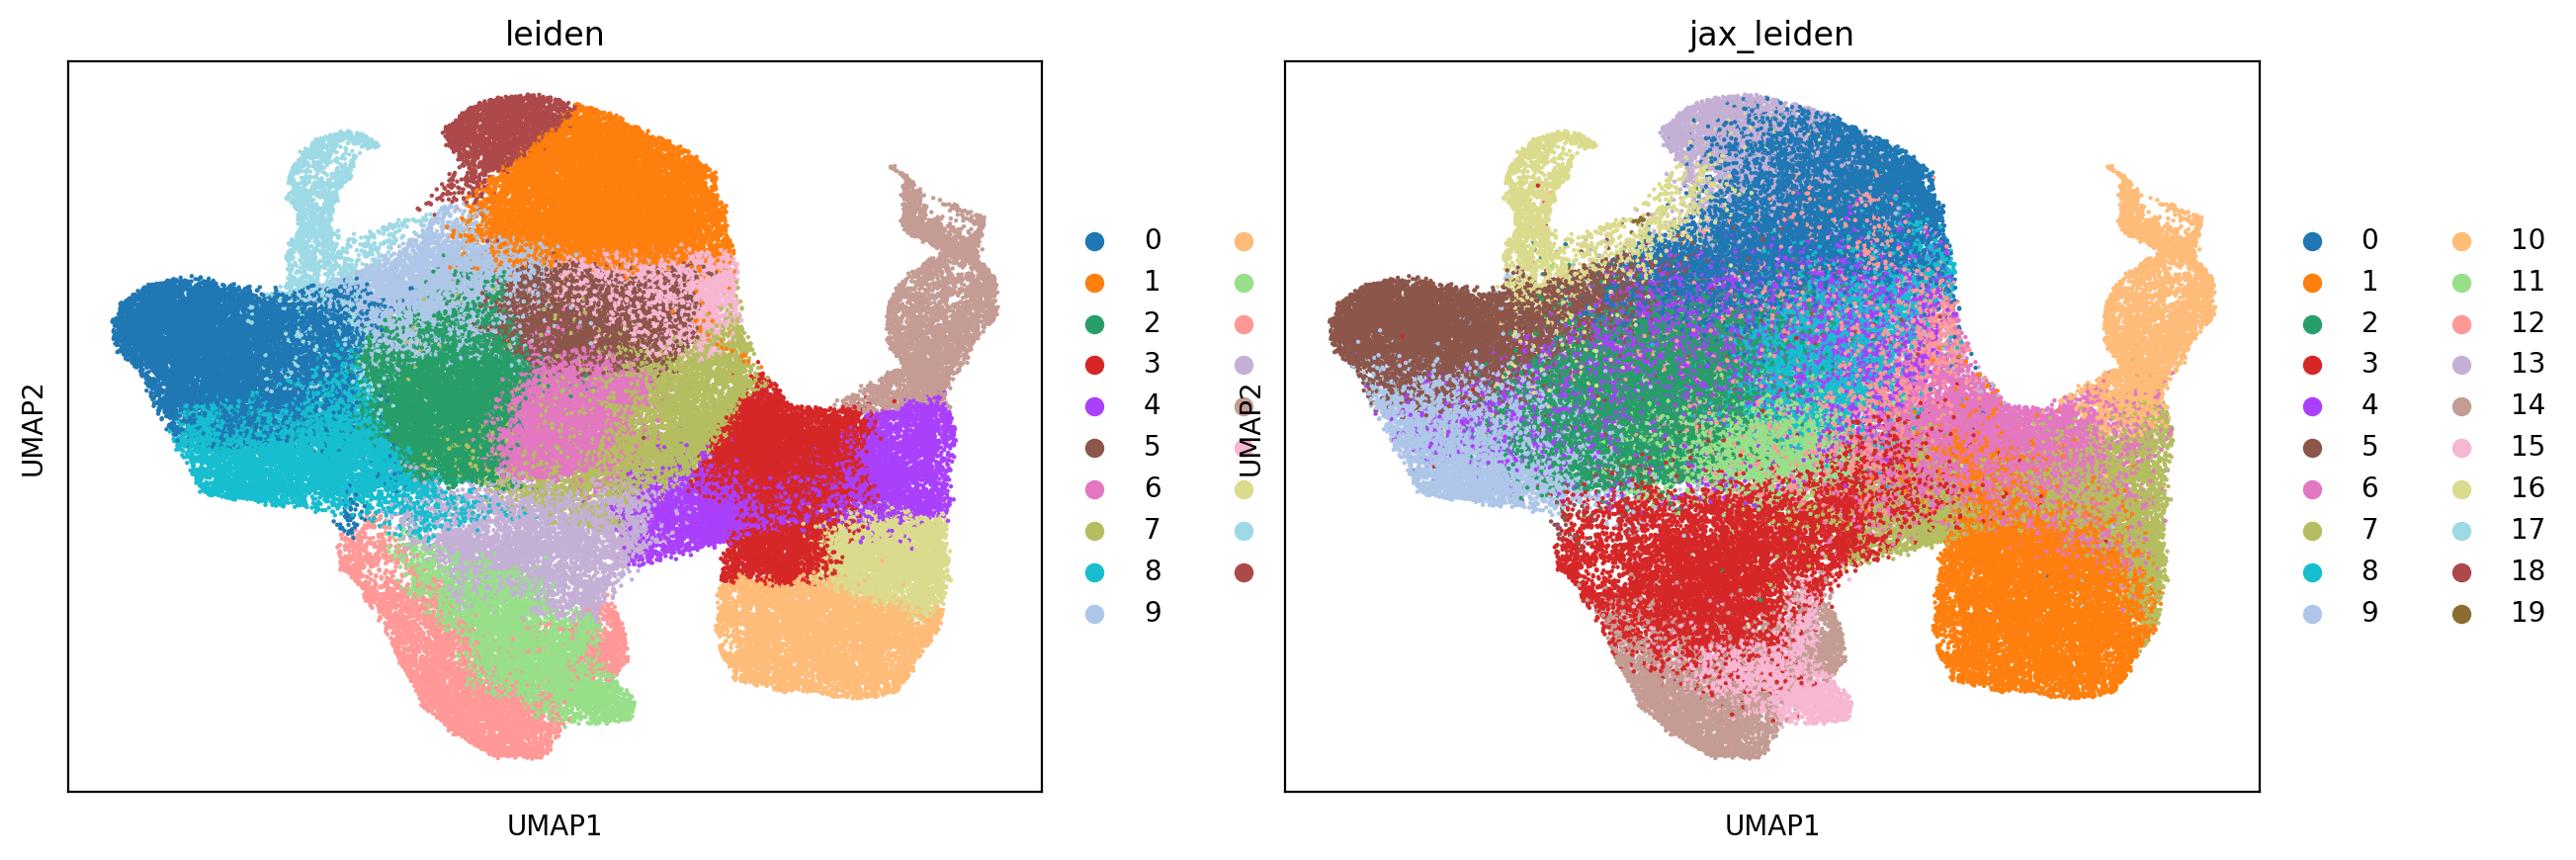

In [52]:
sc.pl.umap(ds, color=["leiden", "jax_leiden"], size=10)

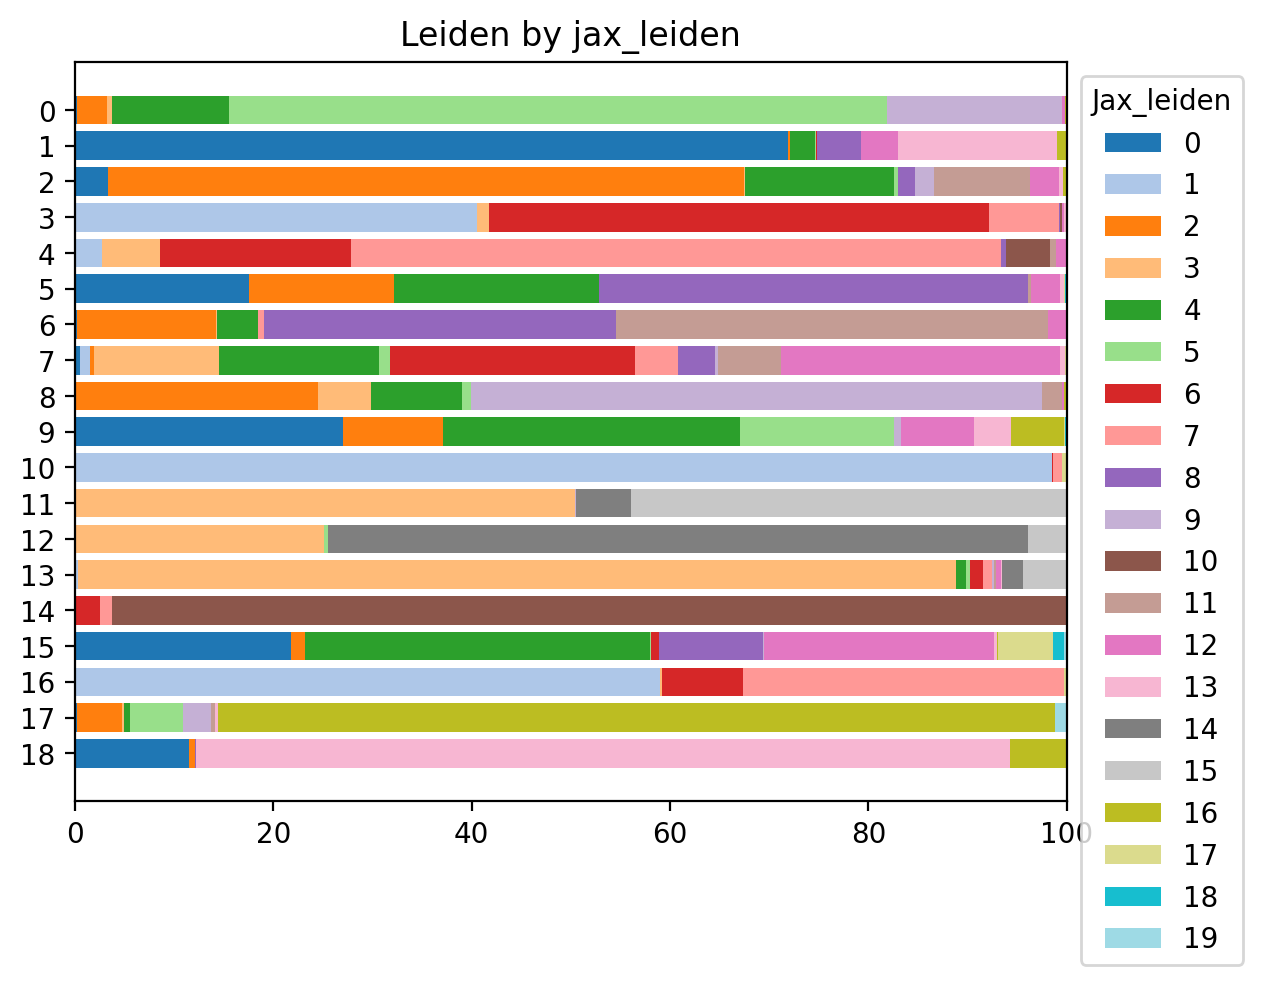

In [61]:
ax = sc_utils.plot_composition(ds, group_by="leiden", color="jax_leiden", relative=True)
ax.legend_._loc = 2
ax.legend_.set_bbox_to_anchor((1, 1))

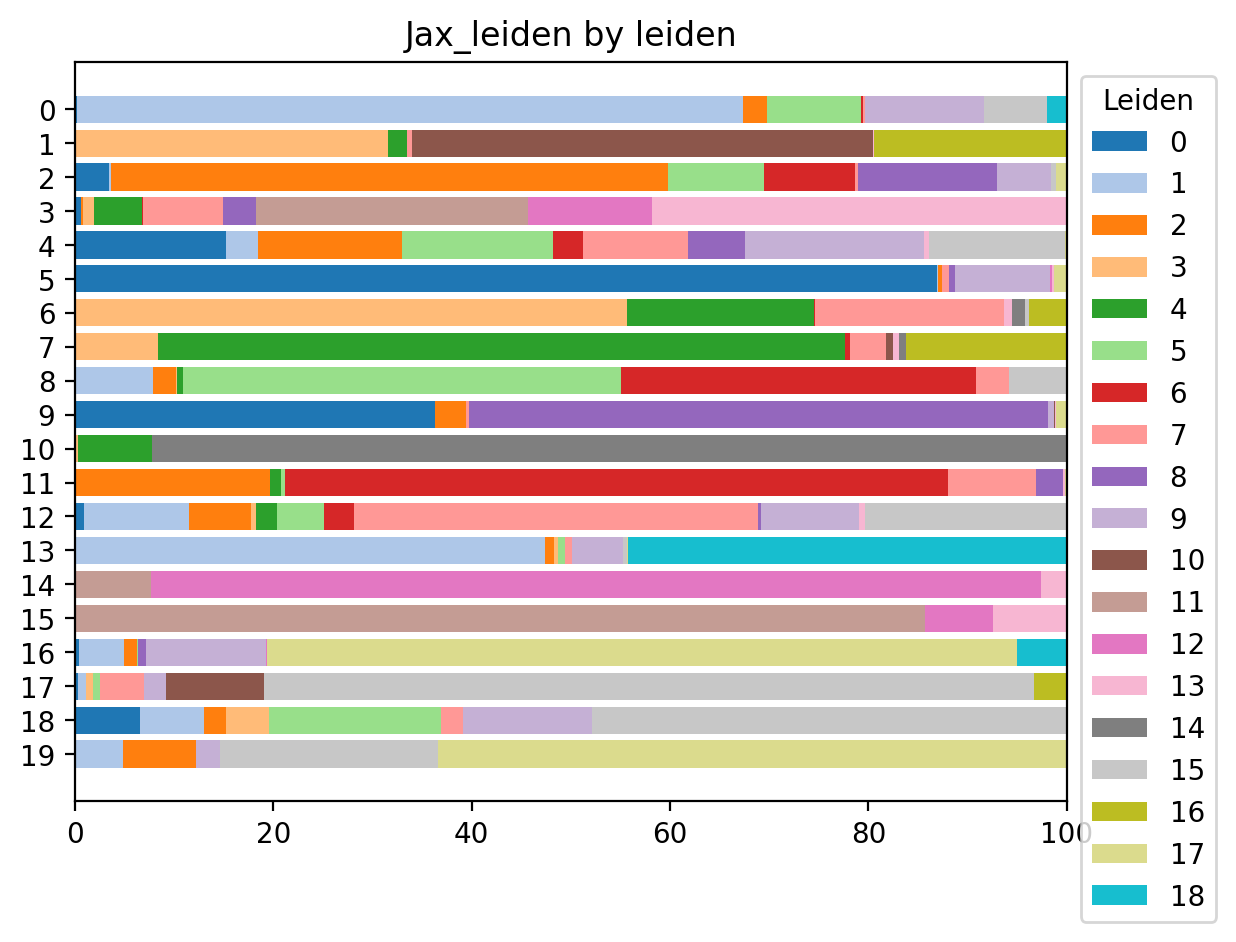

In [62]:
ax = sc_utils.plot_composition(ds, group_by="jax_leiden", color="leiden", relative=True)
ax.legend_._loc = 2
ax.legend_.set_bbox_to_anchor((1, 1))

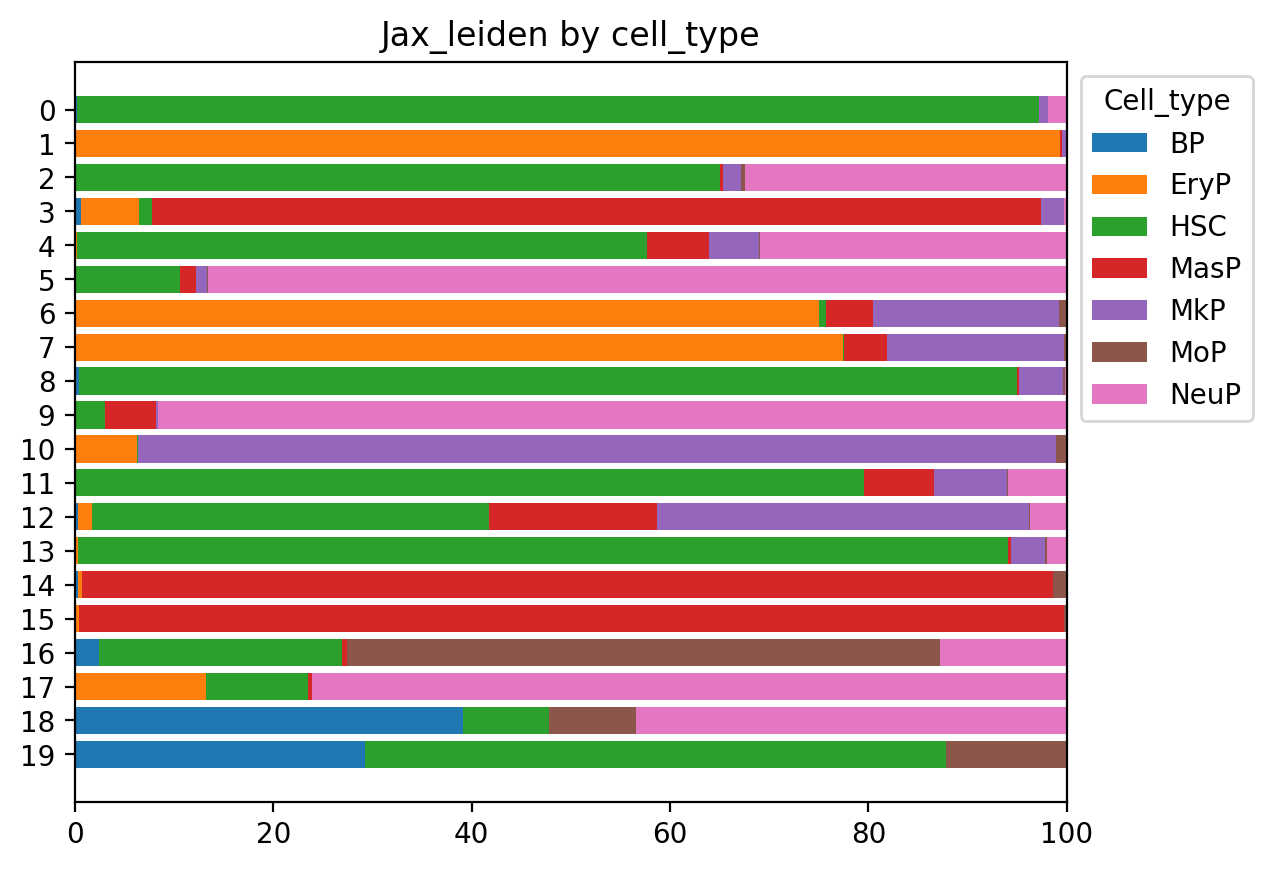

In [63]:
ax = sc_utils.plot_composition(ds, group_by="jax_leiden", color="cell_type", relative=True)
ax.legend_._loc = 2
ax.legend_.set_bbox_to_anchor((1, 1))

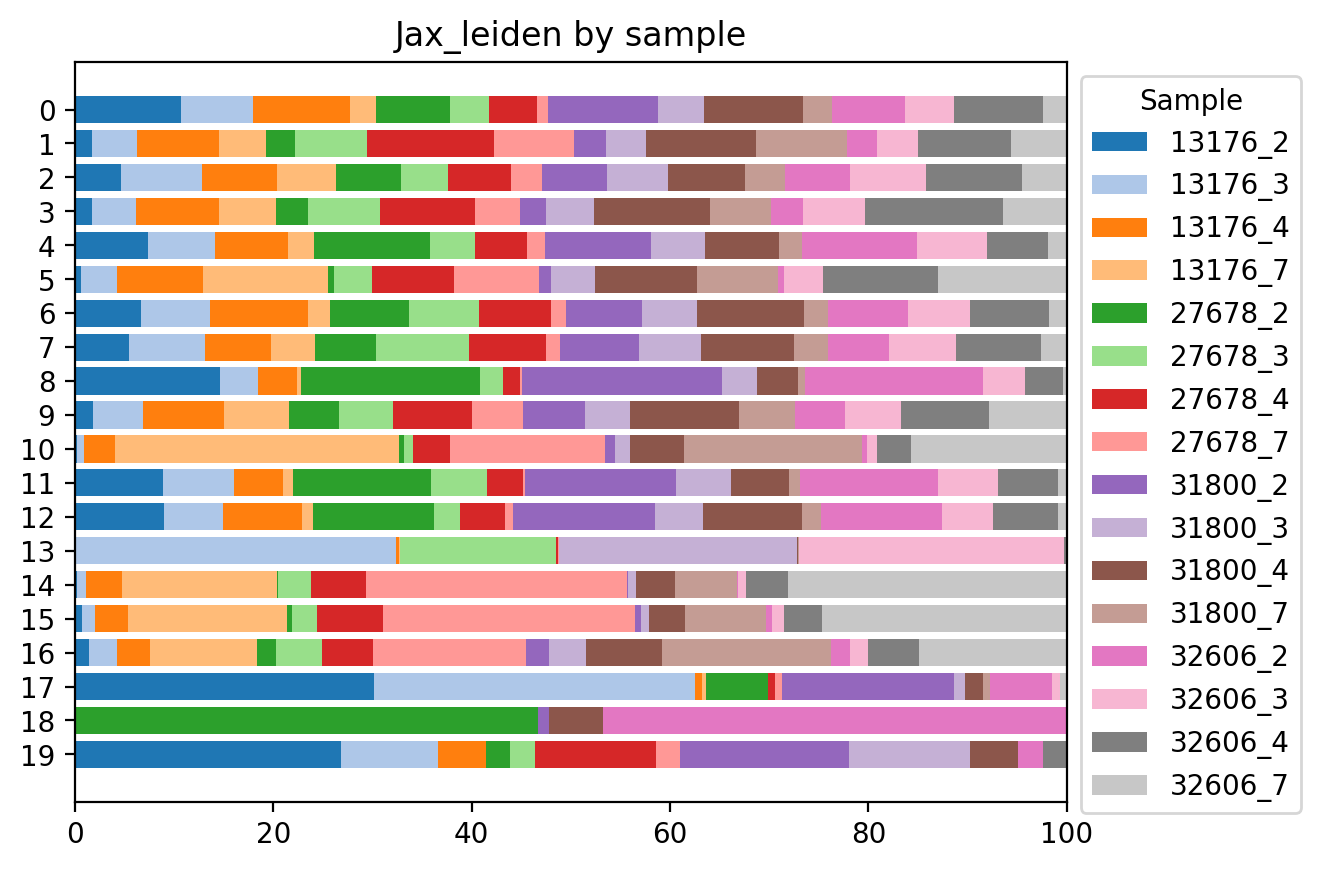

In [64]:
ax = sc_utils.plot_composition(ds, group_by="jax_leiden", color="sample", relative=True)
ax.legend_._loc = 2
ax.legend_.set_bbox_to_anchor((1, 1))

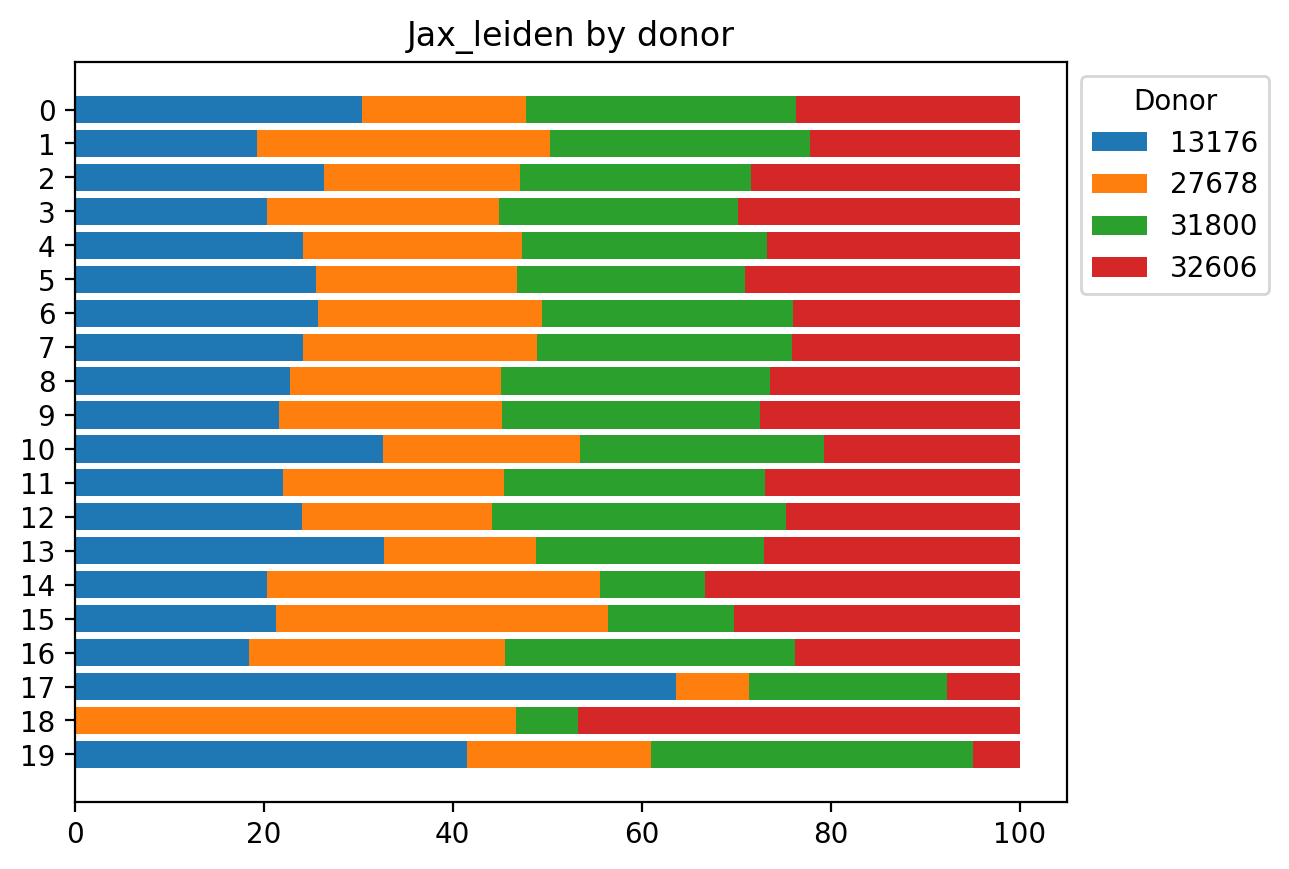

In [66]:
ax = sc_utils.plot_composition(ds, group_by="jax_leiden", color="donor", relative=True)
ax.legend_._loc = 2
ax.legend_.set_bbox_to_anchor((1, 1))

**Conclusion**:
* better agreement with previous analysis than scVI

In [67]:
np.var(ds.obsm["X_jax"], axis=0)

array([1.2903235 , 0.54055357, 0.57781816, 0.4571033 , 0.6493142 ,
       0.40176943, 0.3556411 , 0.5479031 , 0.664333  , 0.7708827 ,
       0.5190544 , 0.5039926 , 0.82268006, 0.4450566 , 0.52069306,
       0.7958526 ], dtype=float32)

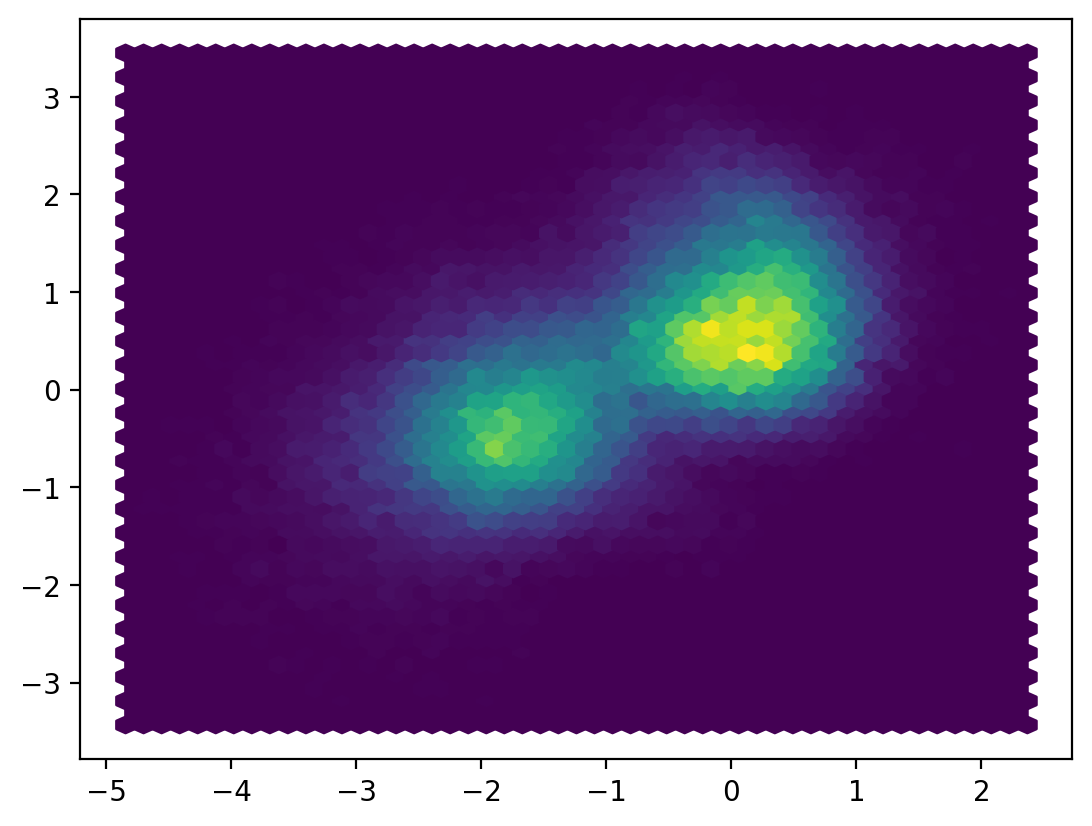

In [94]:
plt.hexbin(ds.obsm["X_jax"][:, 0], ds.obsm["X_jax"][:, 15], gridsize=50)

In [95]:
ds.write_h5ad("../data/h5ad/jax_rna.h5ad")